['no_tumor', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor']
Training Dataset: 
Found 2870 images belonging to 4 classes.
Testing Dataset: 
Found 394 images belonging to 4 classes.
Training model: EfficientNetB3
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 8, 8, 1536)       10783535  
                                                                 
 global_average_pooling2d_2   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 1536)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               196736    
                                                                 
 dropout_5 (Dropout)         (Non

2023-07-24 14:06:03.262241: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


201/201 [==============================] - 114s 258ms/step - loss: 0.5122 - accuracy: 0.8085 - val_loss: 0.4249 - val_accuracy: 0.8423
Epoch 2/32
201/201 [==============================] - 52s 259ms/step - loss: 0.2410 - accuracy: 0.9192 - val_loss: 0.2068 - val_accuracy: 0.9342
Epoch 3/32
201/201 [==============================] - 49s 245ms/step - loss: 0.1451 - accuracy: 0.9491 - val_loss: 0.1260 - val_accuracy: 0.9602
Epoch 4/32
201/201 [==============================] - 49s 245ms/step - loss: 0.0823 - accuracy: 0.9740 - val_loss: 0.0913 - val_accuracy: 0.9755
Epoch 5/32
201/201 [==============================] - 49s 246ms/step - loss: 0.0674 - accuracy: 0.9786 - val_loss: 0.1567 - val_accuracy: 0.9571
Epoch 6/32
201/201 [==============================] - 50s 246ms/step - loss: 0.0490 - accuracy: 0.9812 - val_loss: 0.0851 - val_accuracy: 0.9786
Epoch 7/32
201/201 [==============================] - 49s 246ms/step - loss: 0.0423 - accuracy: 0.9854 - val_loss: 0.1122 - val_accuracy: 0.

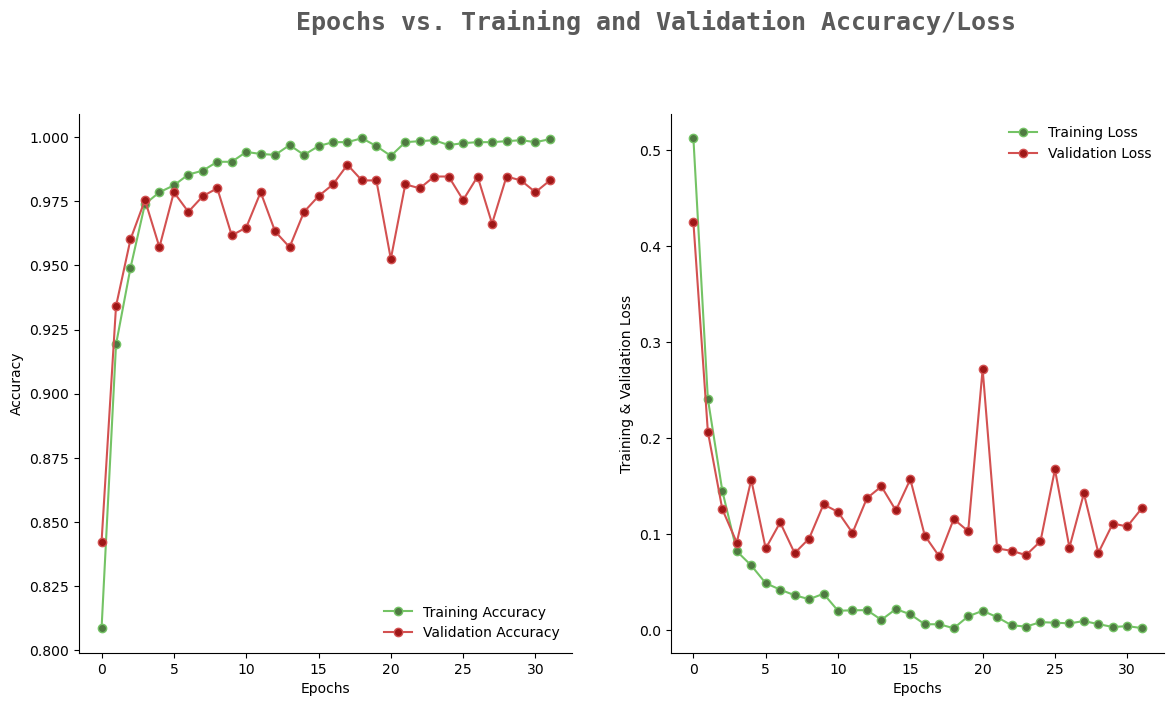

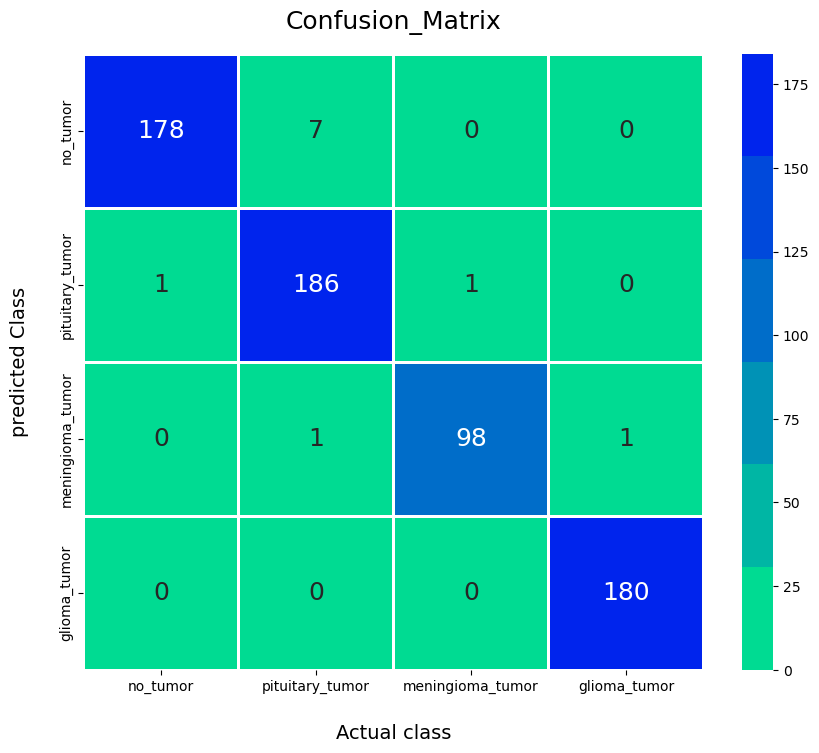

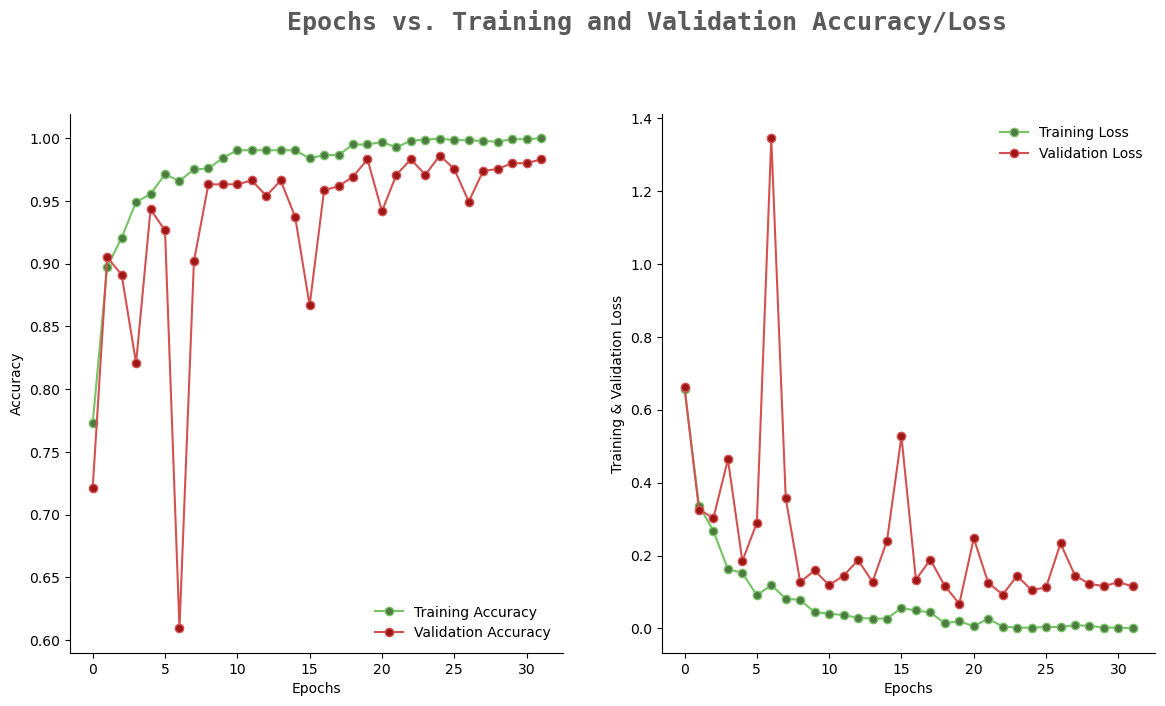

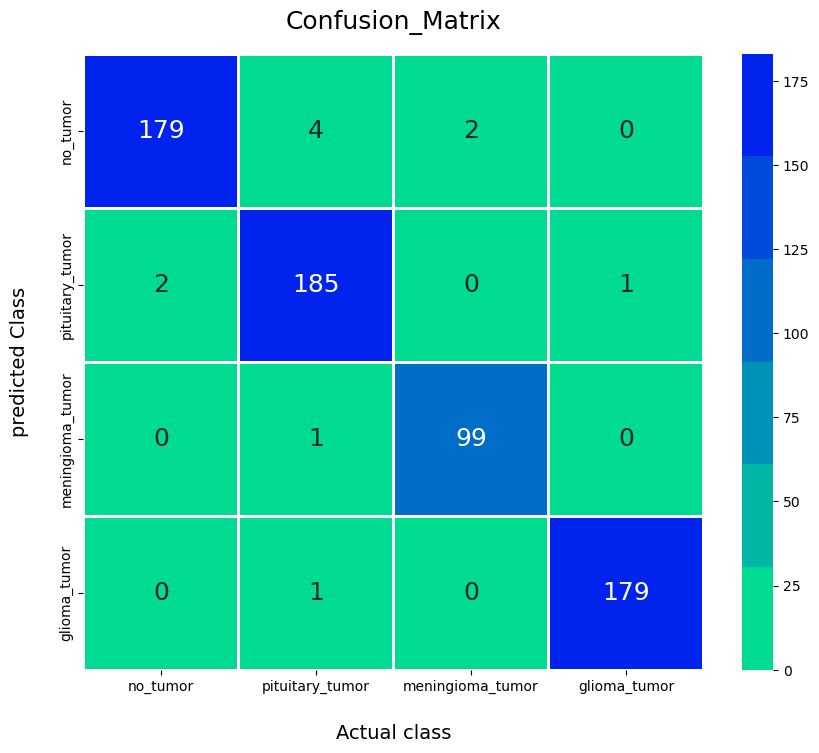

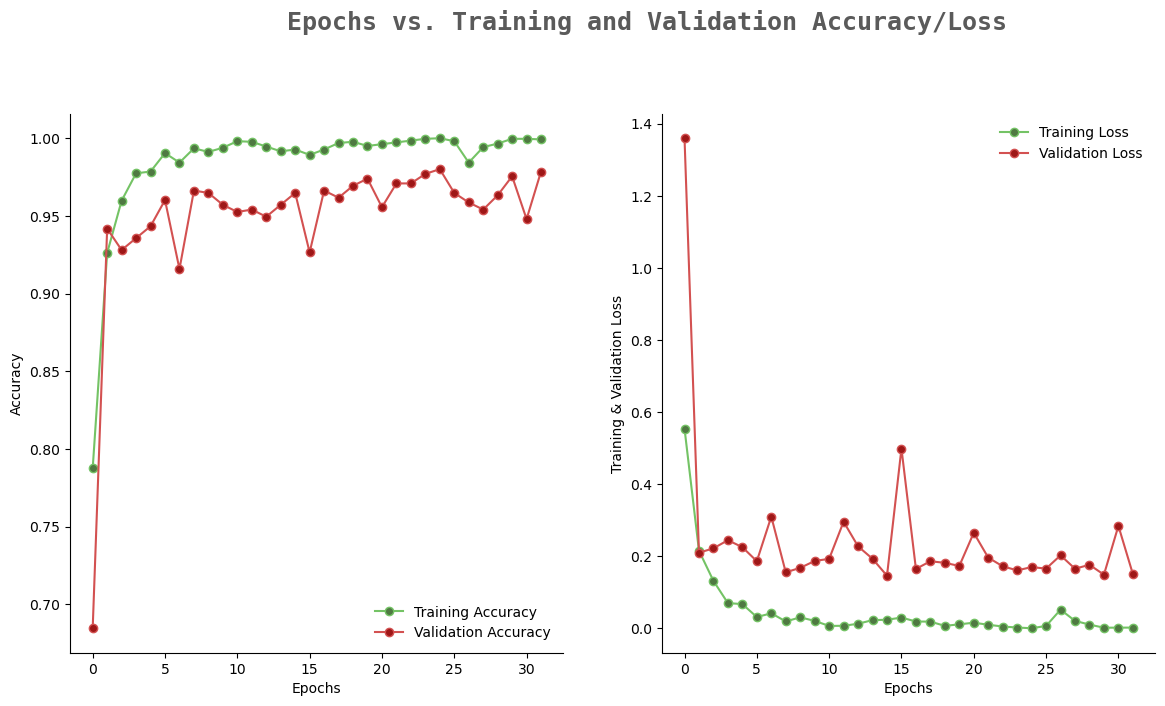

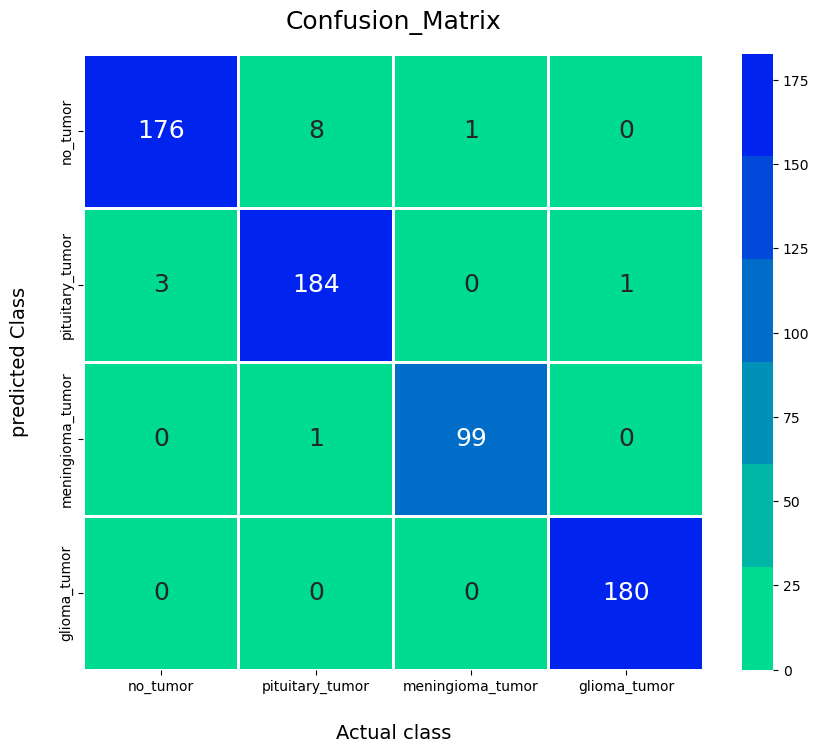

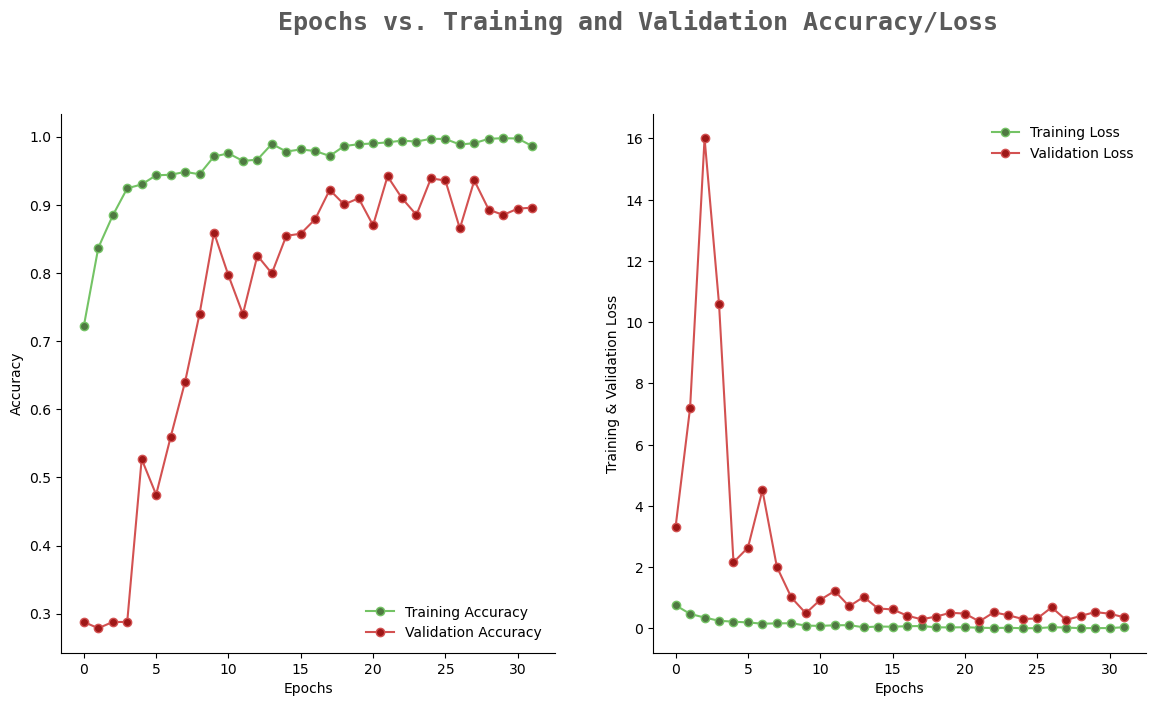

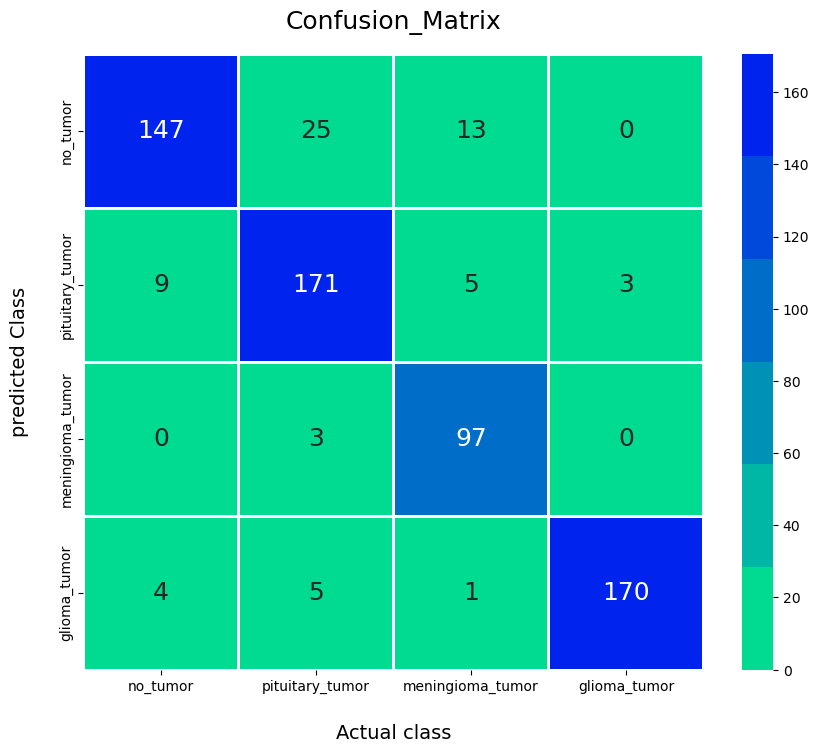

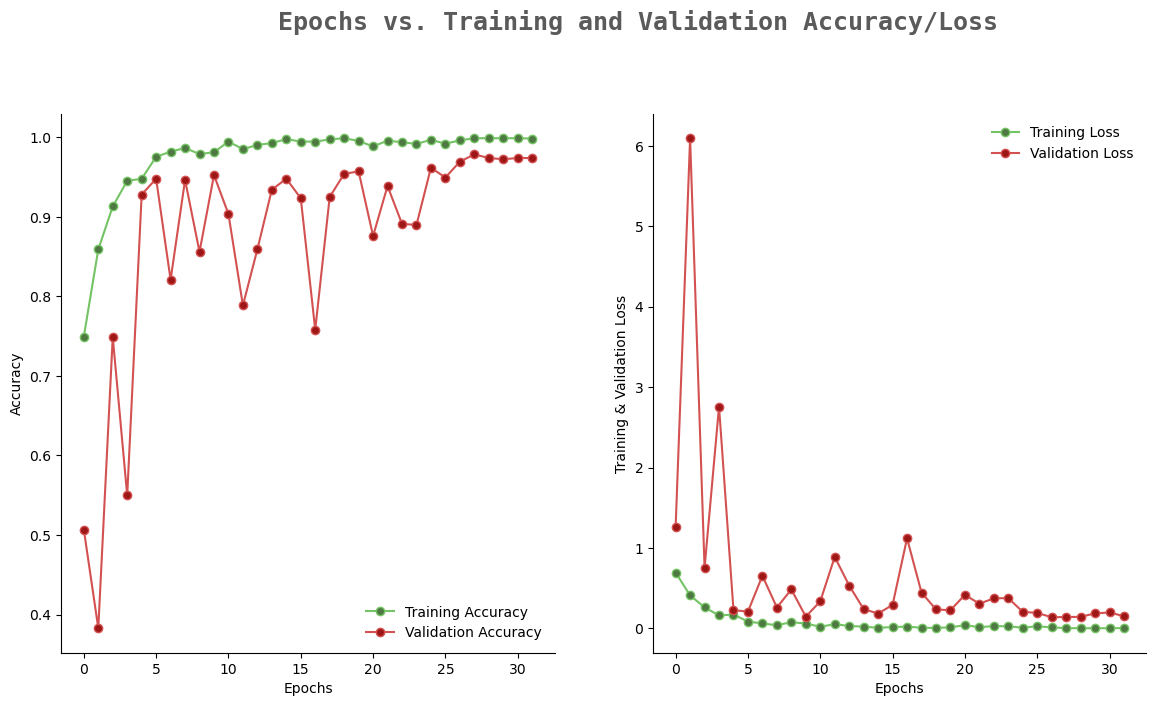

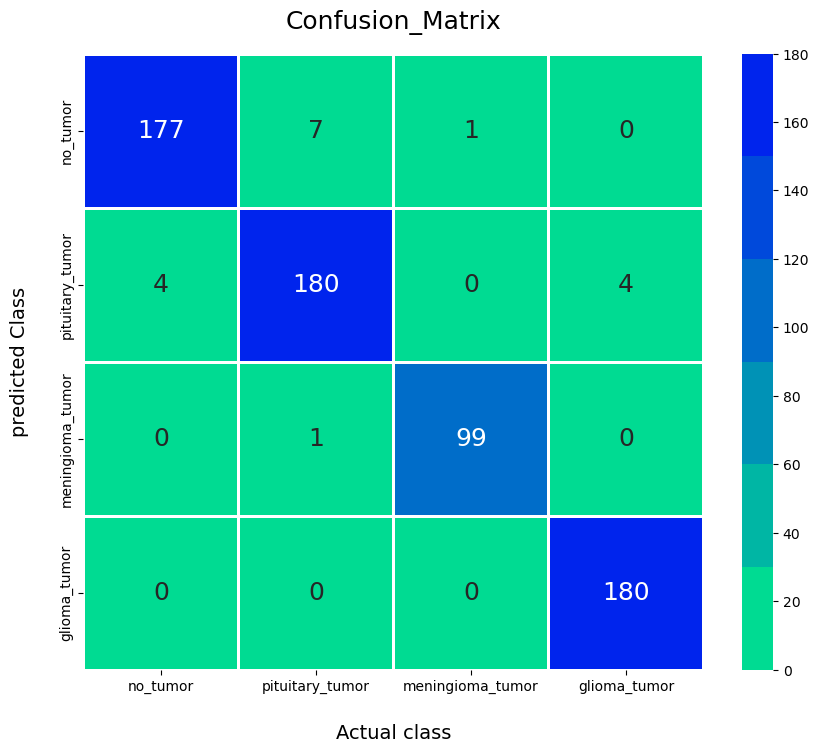

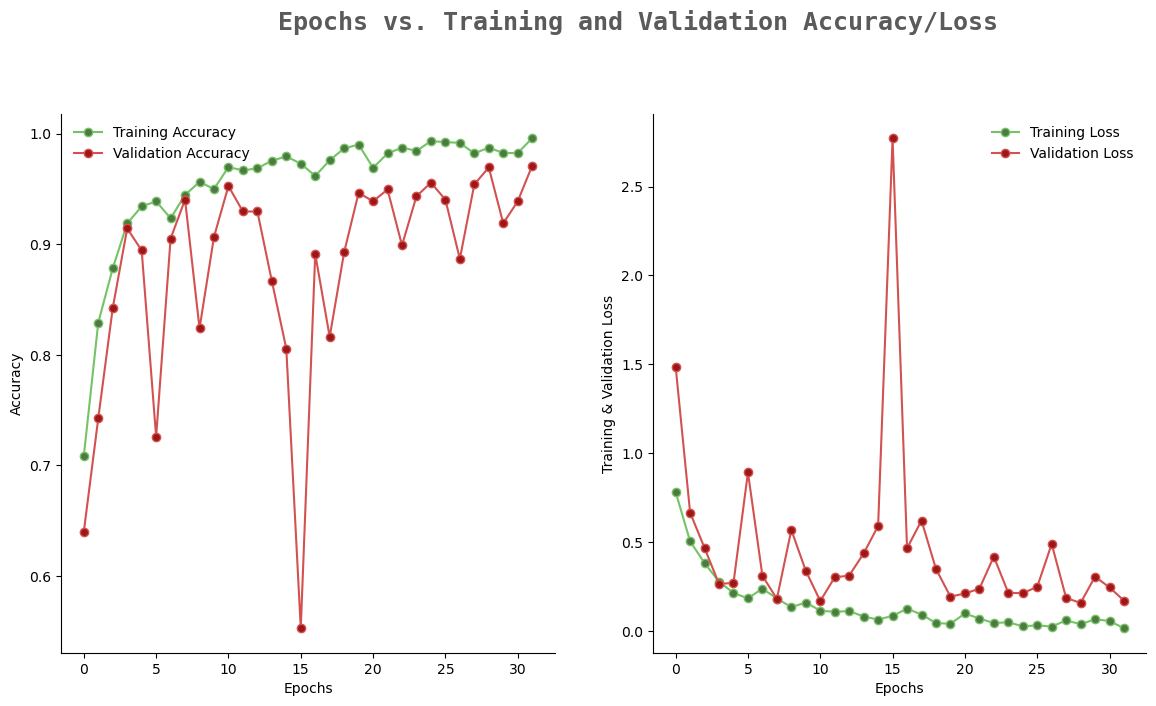

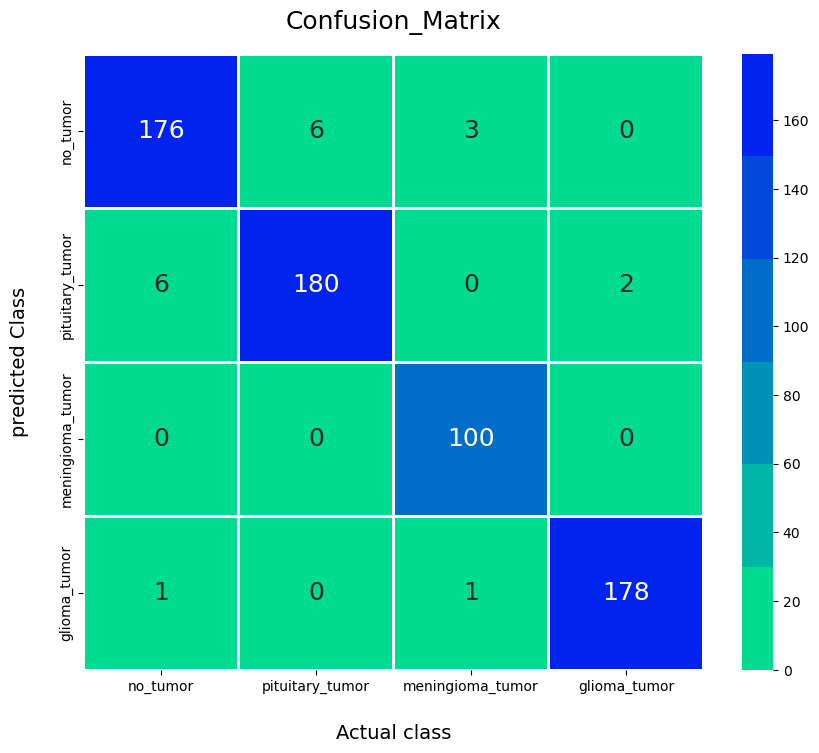

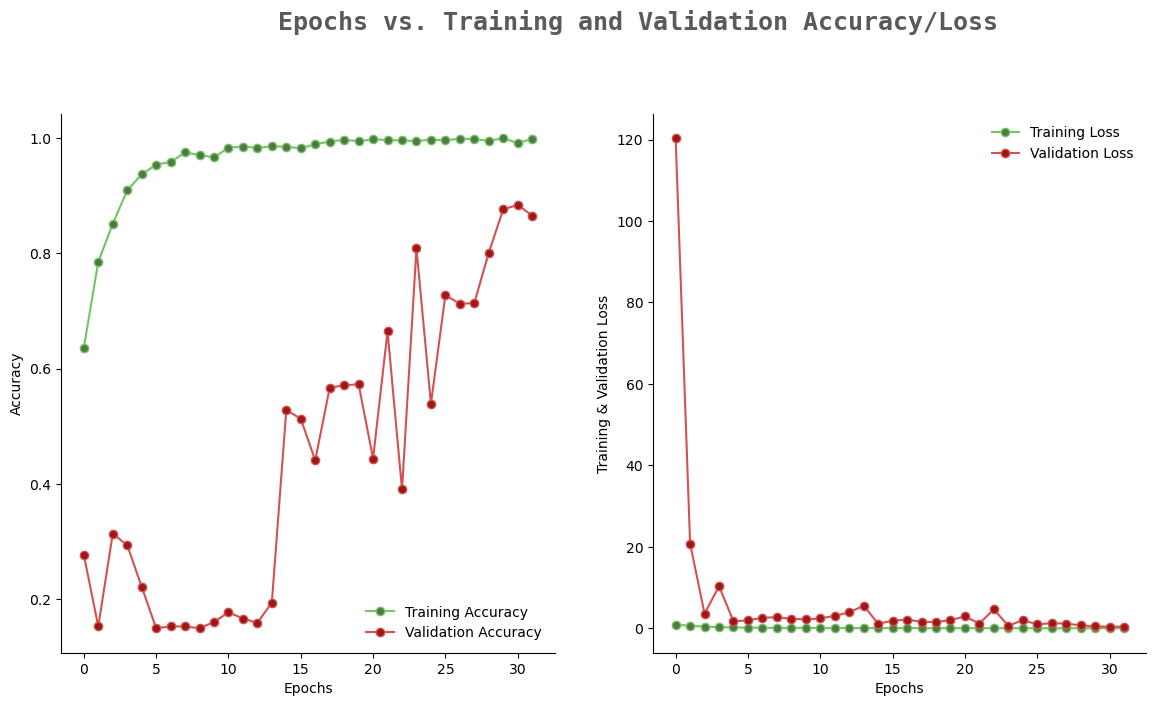

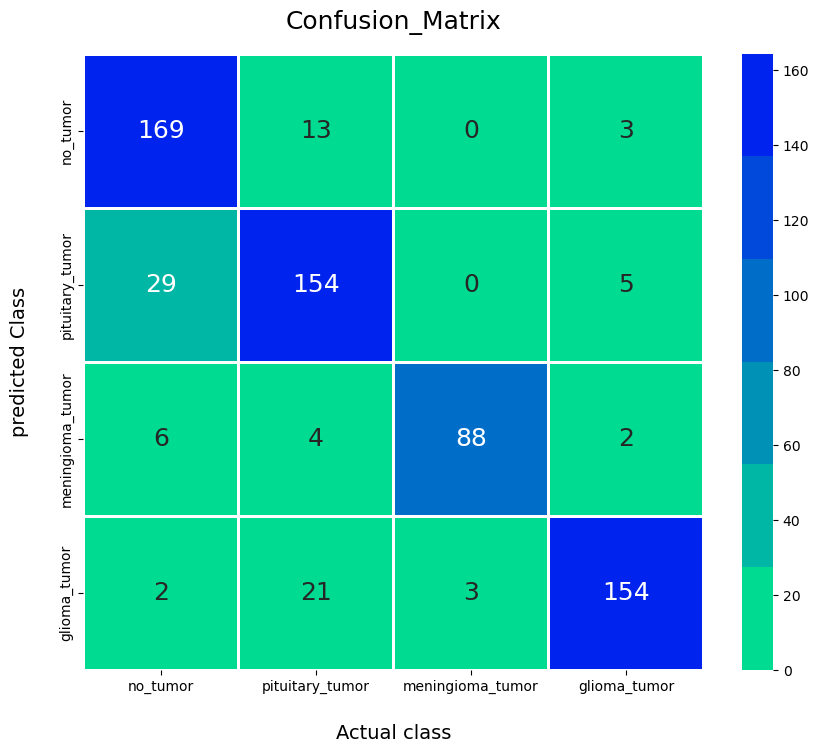

In [3]:
import cv2
import numpy as np
import pandas as pnds
import matplotlib.pyplot as plt
import time
import seaborn as sns
from os import listdir
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB5,EfficientNetB3,EfficientNetB7,InceptionResNetV2,MobileNetV2
from tensorflow.keras.applications import InceptionV3, ResNet50, DenseNet121,VGG16, VGG19, Xception,NASNetMobile
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow.keras.applications as keras_applications
from tensorflow.keras.layers import LSTM, Dense
import keras
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
#from pretty_confusion_matrix import pp_matrix
#confusion_matrix = metrics.confusion_matrix(y_true=y_test_labels, y_pred=pred_labels)  # shape=(12, 12)
from sklearn.metrics import confusion_matrix
from IPython.display import clear_output
# !pip install imutils
# clear_output()
# !pip install tf-nightly
# !pip install keras_efficientnets
# !pip install pretty-confusion-matrix
# import imutils
from IPython.display import clear_output
!pip install imutils
import warnings
# Ignore all warning messages temporarily
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
# clear_output()
# !pip install tf-nightly
# !pip install keras_efficientnets
# !pip install pretty-confusion-matrix
import imutils

colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']


def crop_brain_contour(image):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])


    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    return new_image

# Set random seed for reproducibility
tf.random.set_seed(42)
#Added the image Category
imageCategory=[]
dataPath='/kaggle/input/brain-tumor-classification-mri'
for sub_folder in os.listdir(os.path.join(dataPath,'Training')):
   imageCategory.append(sub_folder)
print(imageCategory)

#print the daetails of training class and testing class

imageGenerator=ImageDataGenerator()
print("Training Dataset: ")
trainDataset=imageGenerator.flow_from_directory('/kaggle/input/brain-tumor-classification-mri/Training')
print("Testing Dataset: ")
testDataset=imageGenerator.flow_from_directory('/kaggle/input/brain-tumor-classification-mri/Testing')


trainDataset.class_indices
trainImageCount=pnds.DataFrame(trainDataset.classes)
trainImageCount.value_counts()

testImageCount=pnds.DataFrame(testDataset.classes)
testImageCount.value_counts()


X_train=[]
Y_train=[]
image_size=240  # 150 245
for i in imageCategory:
  trainPath=os.path.join(dataPath,'Training',i)
  for j in os.listdir(trainPath):
    image=cv2.imread(os.path.join(trainPath,j))
    image=crop_brain_contour(image)
    image=cv2.resize(image,(image_size,image_size))
    X_train.append(image)
    Y_train.append(i)

  testPath=os.path.join(dataPath,'Testing',i)
  for j in os.listdir(testPath):
    image=cv2.imread(os.path.join(testPath,j))
    image=crop_brain_contour(image)
    image=cv2.resize(image,(image_size,image_size))
    X_train.append(image)
    Y_train.append(i)


X_train=np.array(X_train)
Y_train=np.array(Y_train)


X_train,Y_train=shuffle(X_train,Y_train,random_state=42)


# Data Augmentation

dataAugmentation=ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
    )


dataAugmentation.fit(X_train)
X_train.shape

lEncdr=LabelEncoder()

X_train,X_test,Y_train,Y_test=train_test_split(X_train,Y_train,test_size=0.20,random_state=42,stratify=Y_train)
lblTrain=lEncdr.fit(Y_train)
Y_train=lEncdr.transform(Y_train)
Y_test=lEncdr.transform(Y_test)


models = {
    'EfficientNetB3':keras_applications.EfficientNetB3,
    'GoogleNet': keras_applications.InceptionV3,
    'Xception': keras_applications.Xception,
    'MobileNet':keras_applications.MobileNetV2,
    'ResNet50': keras_applications.ResNet50,
#     'AlexNet': keras_applications.AlexNet,
    'DenseNet121': keras_applications.DenseNet121,
#     'VGG16': keras_applications.VGG16,
#     'VGG19': keras_applications.VGG19,
#     'Xception': keras_applications.Xception,
    'NASNetMobile': keras_applications.NASNetMobile
}

history = {}
accuracies = {}
classification_reports = {}
confusion_matrices = {}

for model_name, model_fn in models.items():
    # Print current model name
    print(f"Training model: {model_name}")
    # Load the base model
    base_model = model_fn(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    # Create the model architecture
    model = tf.keras.models.Sequential()
    model.add(base_model)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dropout(rate=0.1))
    model.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer='GlorotNormal'))
    model.add(tf.keras.layers.Dropout(rate=0.1))
    model.add(tf.keras.layers.Dense(4, activation='softmax'))

    # Compile the model
    opt = SGD(learning_rate=0.01,momentum=0.9)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    print(model.summary())
    early_stopping_model=keras.callbacks.EarlyStopping(patience=9,restore_best_weights=True)
    history=model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=32,batch_size=13)

    print()
#     pnds.DataFrame(history.history).plot(figsize=(6,6))
#     plt.grid(True)
#     plt.gca().set_ylim(0,1)

    fig, ax = plt.subplots(1,2,figsize=(14,7))
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    epochs_count = [i for i in range(len(train_acc))]

    fig.text(s='Epochs vs. Training and Validation Accuracy/Loss', size=18, fontweight='bold',
             fontname='monospace', color=colors_dark[1], y=1, x=0.28, alpha=0.8)

    sns.despine()
    ax[0].plot(epochs_count, train_acc, marker='o',markerfacecolor=colors_green[2], color=colors_green[3],label = 'Training Accuracy')
    ax[0].plot(epochs_count, val_acc, marker='o',markerfacecolor=colors_red[2], color=colors_red[3],label = 'Validation Accuracy')
    ax[0].legend(frameon=False)
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')

    sns.despine()
    ax[1].plot(epochs_count, train_loss, marker='o', markerfacecolor=colors_green[2], color=colors_green[3],label='Training Loss')
    ax[1].plot(epochs_count, val_loss, marker='o', markerfacecolor=colors_red[2], color=colors_red[3],label='Validation Loss')
    ax[1].legend(frameon=False)
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Training & Validation Loss')
    fig.show()

    print()
    loss,accuracy=model.evaluate(X_test,Y_test)
    print('Accuracy: %f' %(accuracy*100))
    print()
    Y_test_labels=lEncdr.inverse_transform(Y_test)
    # predict the label inversely
    prediction=np.argmax(model.predict(X_test),axis=1)
    prediction_labels=lEncdr.inverse_transform(prediction)   #prediction labels
    pnds.Series(prediction_labels).value_counts()
    print()
    confusionMatrix=confusion_matrix(Y_test,prediction)
    fig,axis=plt.subplots(figsize=(10,8))
    colorPlate=sns.color_palette("winter_r")
    sns.heatmap(confusionMatrix,annot=True,fmt='g',linewidths=1,linecolor='white',robust=True,annot_kws={"size":18},cmap=colorPlate)
    axis.xaxis.set_ticklabels(imageCategory)
    axis.yaxis.set_ticklabels(imageCategory)
    plt.yticks(va="center")
    plt.title("Confusion_Matrix",fontsize=18,pad=18)
    plt.xlabel("Actual class",labelpad=22,fontsize=14)
    
    plt.ylabel("predicted Class",labelpad=22,fontsize=14)
    print()
    print(classification_report(Y_test,prediction,target_names=imageCategory))
    print()
    #lt.savefig(os.path.join('/content/drive/MyDrive/Tumor_Dataset/Brain-Tumor/','confusionMatrix-crop.png'),dpi=300)